In [1]:
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.model_selection import train_test_split


In [2]:
# Load the stock market data (replace with your own data source)
data = pd.read_csv('stock_prices.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values)


In [3]:
# Prepare the data for LSTM


def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


In [4]:
look_back = 10  # Choose the number of previous time steps to use as input
X, y = prepare_data(data_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# Create an array of the dates corresponding to the test set
test_indices = data.index[X.shape[0] - len(X_test):]

input_shape = (X_train.shape[1], X_train.shape[2])


In [5]:
def create_lstm_model(units, dropout_rate, input_shape):
    model = Sequential()
    model.add(LSTM(units=int(units), return_sequences=True,
              input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=int(units), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=int(units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [6]:
# Define the evaluation function


def evaluate_lstm(individual, X_train, y_train, input_shape):
    model = create_lstm_model(individual[0], individual[1], input_shape)
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    loss = history.history['loss'][-1]
    return (1 / (1 + loss),)


# Set up the genetic algorithm
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

# Define the custom mutation function


In [7]:

def custom_mutation(individual, indpb_units=0.1, indpb_dropout_rate=0.1):
    if random.random() < indpb_units:
        individual[0] = toolbox.units()
    if random.random() < indpb_dropout_rate:
        individual[1] = toolbox.dropout_rate()
    return individual,


In [8]:

toolbox = base.Toolbox()
toolbox.register('units', random.randint, 10, 200)
toolbox.register('dropout_rate', random.uniform, 0, 0.5)
toolbox.register('individual', tools.initCycle, creator.Individual,
                 (toolbox.units, toolbox.dropout_rate), n=1)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('mate', tools.cxBlend, alpha=0.5)
toolbox.register('mutate', custom_mutation,
                 indpb_units=0.1, indpb_dropout_rate=0.1)
toolbox.register('select', tools.selBest)
toolbox.register('evaluate', evaluate_lstm, X_train=X_train,
                 y_train=y_train, input_shape=input_shape)


In [ ]:
population = toolbox.population(n=20)  # Number of individuals
ngen = 5  # Number of generations
result = algorithms.eaSimple(
    population, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=True)

# Get the best individual from the optimization
best_individual = tools.selBest(population, 1)[0]
best_model = create_lstm_model(
    best_individual[0], best_individual[1], input_shape)

# Train the best model on the entire training data
history = best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


In [ ]:
# Predict the test data
predicted_prices_scaled = best_model.predict(X_test)

# Create an empty array with the same shape as the scaled data
predicted_prices_array = np.zeros(
    shape=(len(predicted_prices_scaled), data_scaled.shape[1]))

# Replace the predicted price column in the empty array with the predicted prices
predicted_prices_array[:, 0] = predicted_prices_scaled.ravel()

# Inverse transform the modified array
predicted_prices = scaler.inverse_transform(predicted_prices_array)[:, 0]

# Create an empty array with the same shape as the scaled data for actual prices
actual_prices_array = np.zeros(shape=(len(y_test), data_scaled.shape[1]))

# Replace the price column in the empty array with the actual prices
actual_prices_array[:, 0] = y_test.ravel()

actual_prices = scaler.inverse_transform(actual_prices_array)[:, 0]

# Get the test dates (assuming the 'Date' column is present in the original data)

y_test_df = pd.DataFrame(y_test, columns=['Price'])
# Convert y_test to a pandas dataframe and get its indices
test_indices = data.index[y_test_df.index]

c:\Python311\Lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Python311\Lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	20    
1  	14    
2  	14    
3  	9     
4  	16    
5  	11    
Epoch 1/10
46/46 [==============================] - 23s 381ms/step - loss: 0.0211
Epoch 2/10
46/46 [==============================] - 26s 567ms/step - loss: 0.0012
Epoch 3/10
46/46 [==============================] - 20s 432ms/step - loss: 0.0011
Epoch 4/10
46/46 [==============================] - 19s 417ms/step - loss: 0.0011
Epoch 5/10
46/46 [==============================] - 20s 434ms/step - loss: 0.0010
Epoch 6/10
46/46 [==============================] - 19s 414ms/step - loss: 9.5292e-04
Epoch 7/10
46/46 [==============================] - 18s 398ms/step - loss: 0.0011
Epoch 8/10
46/46 [==============================] - 18s 385ms/step - loss: 0.0013
Epoch 9/10
46/46 [==============================] - 17s 377ms/step - loss: 0.0011
Epoch 10/10
12/12 [==============================] - 2s 99ms/step


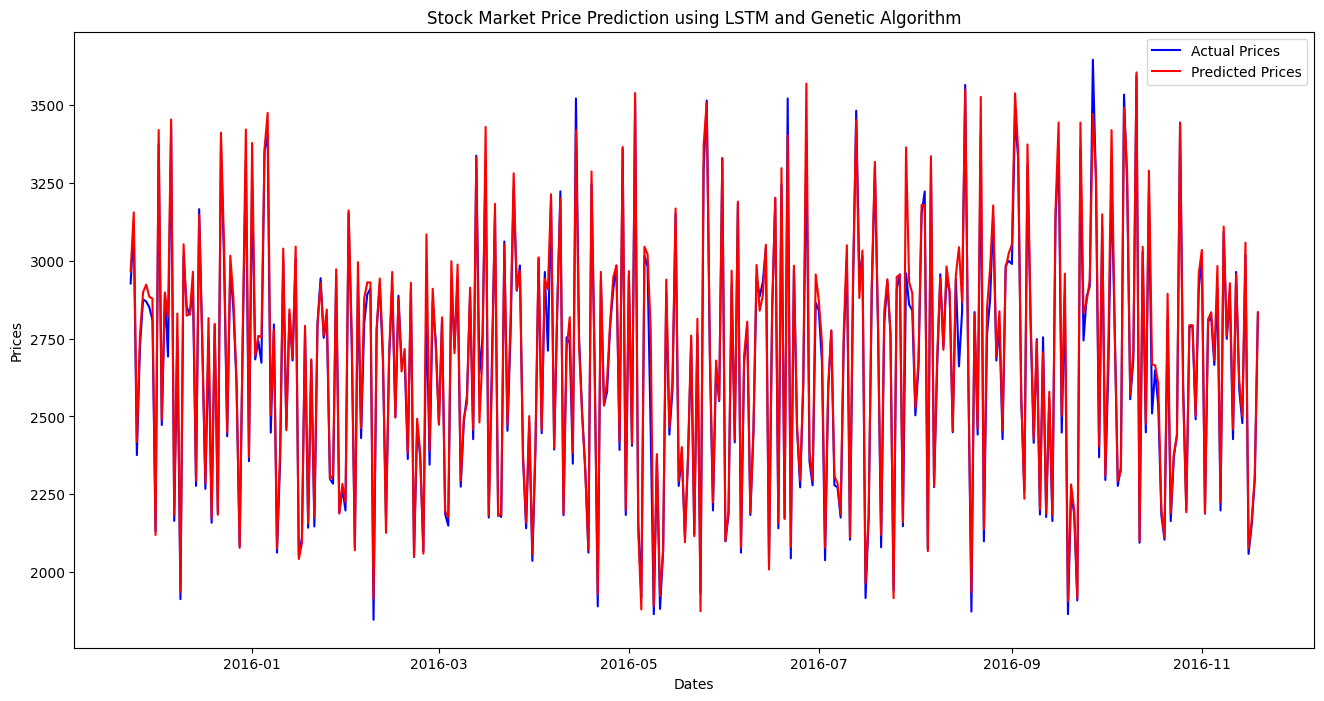

In [3]:

def plot_predictions(test_dates, actual_prices, predicted_prices):
    plt.figure(figsize=(16, 8))
    plt.plot(test_dates, actual_prices, color='blue', label='Actual Prices')
    plt.plot(test_dates, predicted_prices,
             color='red', label='Predicted Prices')
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    plt.title('Stock Market Price Prediction using LSTM and Genetic Algorithm')
    plt.legend()
    plt.show()

plot_predictions(test_indices, actual_prices, predicted_prices)

